In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phaseportrait as pp
from scipy.constants import convert_temperature as conv_temp

from controllers import ControllerBase
from controllers import PIDController
from controllers import PIDController_T_top
from controllers import LQRControllerDisc
from controllers import LQRControllerCont
from controllers import MPCController
from classes import LEDparams, Model
from system import Simulation

In [55]:
num_P_rad = 1
P_rad_vec = np.linspace(0, 1, num_P_rad)
display('P_rad_vec', P_rad_vec)

'P_rad_vec'

array([0.])

0


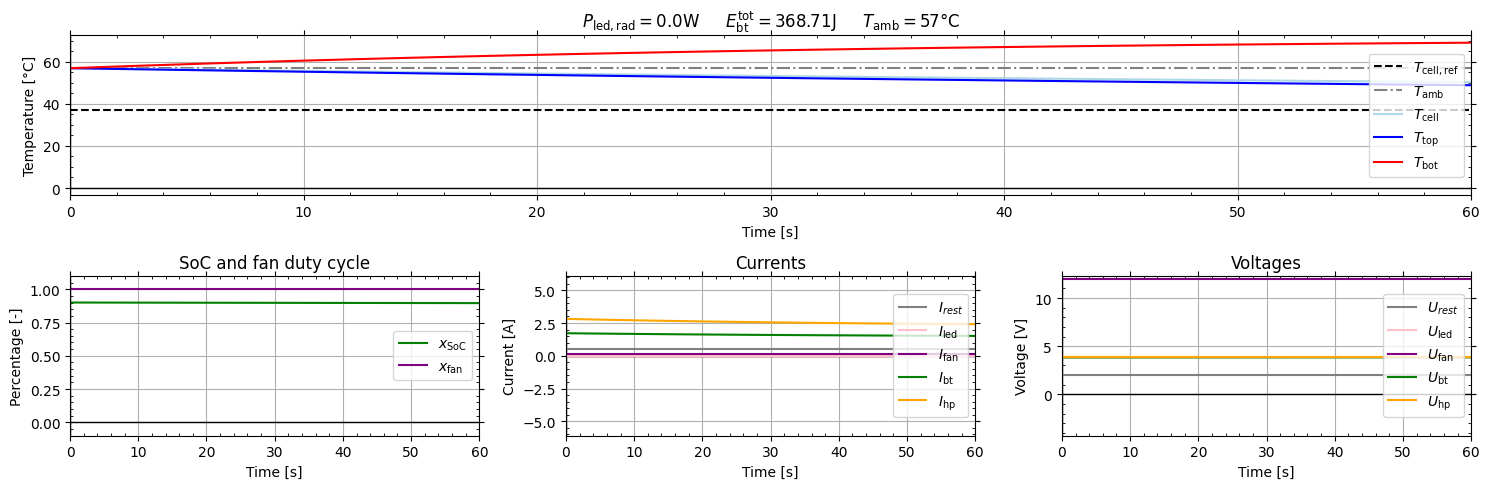

Current DT: -20, Current is tracking: False


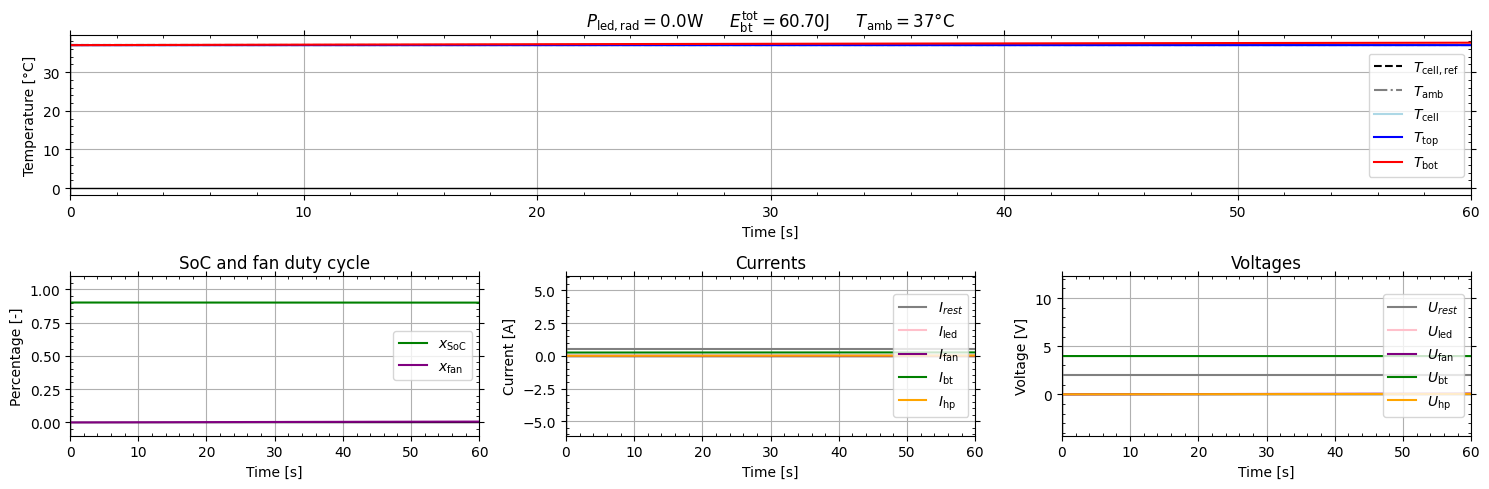

Current DT: 0, Current is tracking: True


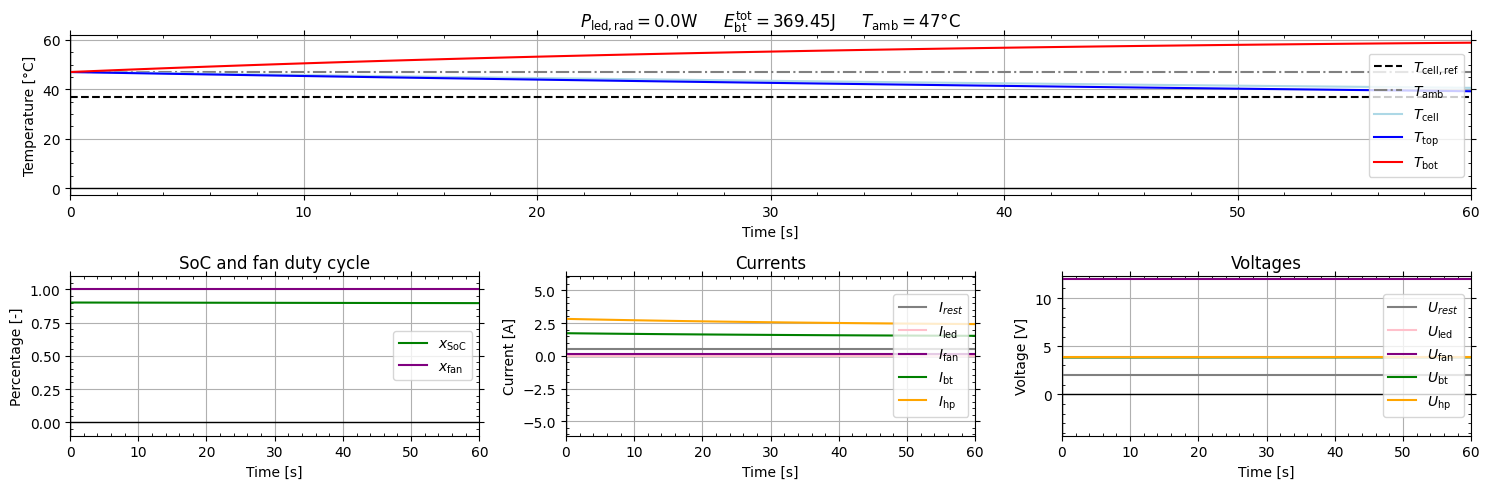

Current DT: -10.0, Current is tracking: False


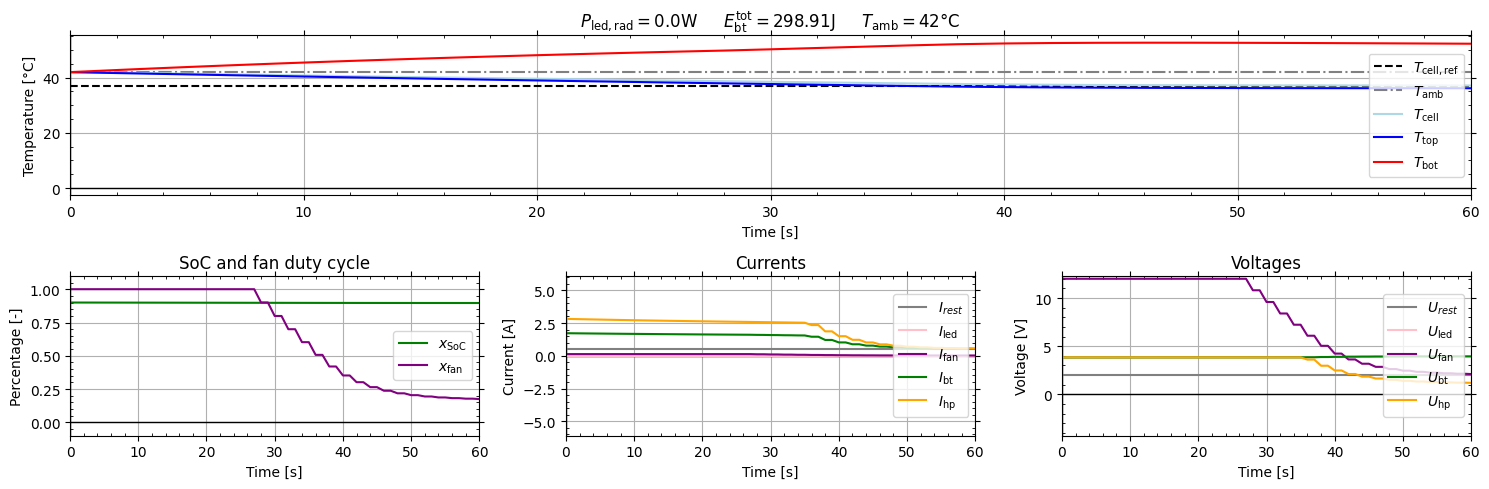

Current DT: -5.0, Current is tracking: True


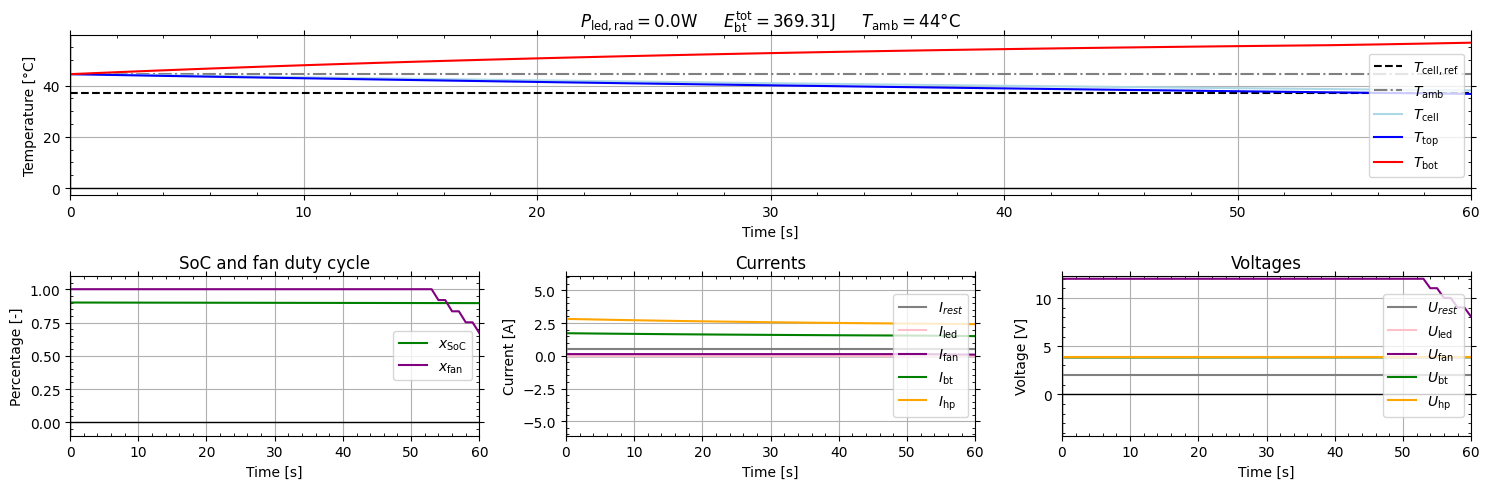

Current DT: -7.5, Current is tracking: False


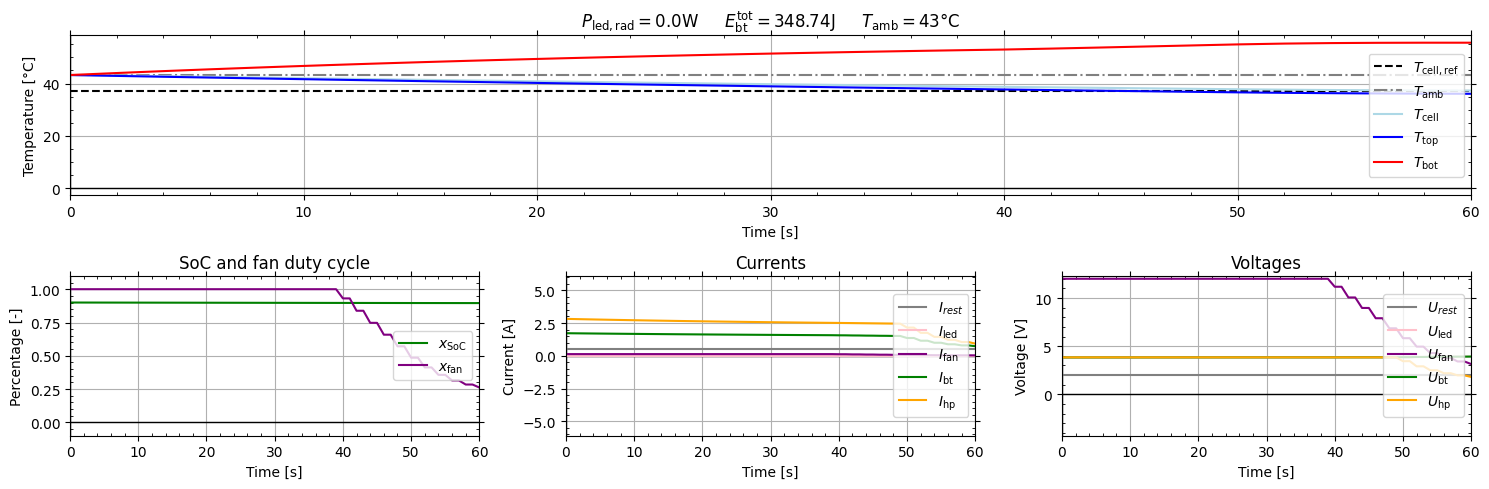

Current DT: -6.25, Current is tracking: True
Stop condition reached.


In [56]:
### Parameters
# Simulation
dt_sim = 1.0 # s
time_span = 60.0 * 1 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

# LED
LEDpar = LEDparams()

# Controller
dt_d = 2.0
T_cell_ref = conv_temp(37.0, 'C', 'K') # K

# Initialize
tracking_tol = 0.5 # °C or K
current_DT = -20 # °C or K
DT_vec = np.array([current_DT])
DT_step = 20 # °C or K

current_is_tracking = False
prev_false_DT = None
prev_true_DT = None

stop_cond_DT = 1 # K

num_P_rad = 1
P_rad_vec = np.linspace(0, 1, num_P_rad)

## Start simulation loop
sim_results_list = []
leg_titles = []
sim_num = 0
for P_rad_iter in range(num_P_rad):
    print(P_rad_iter)
    while True:
        # First iterable variable
        x_LED_tot, I_LED, P_rad = LEDpar.get_x_from_P_rad(P_rad_vec[P_rad_iter])

        # Second iterable variable
        T_amb = T_cell_ref - current_DT

        # Initial conditions
        x0 = np.array([0.9,
                       T_amb,
                       T_amb])
        
        # Model
        model = Model(LEDpar, x0, T_amb0=T_amb)

        T_top_ref = T_amb + (T_cell_ref - T_amb) * (model.R_top_cell + model.R_cell_amb) / model.R_cell_amb

        # LQR
        q1 = 0
        q2 = 20 #/ (T_amb0**2)
        q3 = 0
        Q = np.array([[q1, 0, 0],
                      [0, q2, 0],
                      [0, 0, q3]])
        r1 = 10 / model.I_HP_max**2
        r2 = 4
        R = np.array([[r1, 0 ],
                      [0,  r2]])

        Ad, Bd, hd, Cd, Dd, ld = model.get_discrete_linearization(T_ref=T_cell_ref, T_amb=T_amb, dt_d=dt_d)
        lqr_controller_disc    = LQRControllerDisc(T_top_ref=T_top_ref, T_cell_ref=T_cell_ref, A_d=Ad, B_d=Bd, Q=Q, R=R, sampling_time=dt_d)

        # Simulation
        sim = Simulation(model=model, controller=lqr_controller_disc, dt_sim=dt_sim, time_span=time_span)

        # Run the simulation
        results = sim.run(with_initial_time=False, initial_time_span=10)
        
        results['id_sim']    = sim_num
        results['id_traj_1'] = P_rad_iter
        results['id_traj_2'] = current_DT
        sim_results_list.append(results)

        # Titles for legend and figures
        title_T_amb = r"$T_\mathrm{amb} =$" + f"{round(conv_temp(T_amb, 'K', 'C'))}°C"
        title_P_rad = r"$P_\mathrm{led,rad} =$" + f"{P_rad:.1f}W"
        
        # P_LED = np.mean(results["U_BT"].to_numpy()) * I_LED * x_LED_tot # W
        # title_P_LED = r"$P_\mathrm{LED} =$" + f"{P_LED:.1f}W"

        E_BT_tot = np.trapezoid(results["U_BT"].to_numpy() * results["I_BT"].to_numpy(), results["time"].to_numpy()) # J
        title_E_BT = r"$E_\mathrm{bt}^\mathrm{tot} =$" + f"{E_BT_tot:.2f}J"

        fig_title = title_P_rad + "     " + title_E_BT + "     " + title_T_amb
        leg_title = title_P_rad + "," + title_T_amb

        leg_titles.append(leg_title)

        # Save plot
        filename = f"T_amb_{round(conv_temp(T_amb, 'K', 'C'))}" + "_" + f"P_rad_{P_rad:.1f}W"
        filename = filename.replace(".", "_")

        # Plot sim results
        sim.plot_time_results(fig_title, save_plot=False, filename=filename)
        # sim.plot_current_temperature(fig_title, save_plot=False, filename=filename)

        # Increase counter
        sim_num = sim_num + 1

        ### Grid search
        # Check tracking condition
        current_is_tracking = abs(results["T_cell"].iloc[-1] - T_cell_ref) <= tracking_tol
        print(f"Current DT: {current_DT}, Current is tracking: {current_is_tracking}")

        # First call until both not None: found a tracking and not tracking solution
        if prev_false_DT is None and prev_true_DT is None:
            if current_is_tracking:
                prev_true_DT = current_DT
                current_DT = current_DT - DT_step # Go down
            else:
                prev_false_DT = current_DT
                current_DT = current_DT + DT_step # Go up

        # If previous is tracking
        elif prev_false_DT is None and prev_true_DT is not None:
            if current_is_tracking:
                prev_true_DT = current_DT
                current_DT = current_DT - DT_step # Go down
            else:
                prev_false_DT = current_DT
                # step size halving
                DT_step = DT_step / 2
                current_DT = (prev_true_DT + prev_false_DT) / 2

        # If previous is not tracking
        elif prev_false_DT is not None and prev_true_DT is None:
            if current_is_tracking:
                prev_true_DT = current_DT
                # step size halving
                DT_step = DT_step / 2
                current_DT = (prev_true_DT + prev_false_DT) / 2
            else:
                prev_false_DT = current_DT
                current_DT = current_DT + DT_step # Go up
        
        # If both not None
        else:
            if current_is_tracking:
                prev_true_DT = current_DT
            else:
                prev_false_DT = current_DT

            # step size halving
            DT_step = DT_step / 2
            current_DT = (prev_true_DT + prev_false_DT) / 2

        # Stop condition
        if abs(DT_step) <= stop_cond_DT:
            print("Stop condition reached.")
            break

# All results
all_results_df = pd.concat(sim_results_list).set_index(['id_sim', 'id_traj_1', 'id_traj_2', 'time'])

In [57]:
assert False, "Stop here"

AssertionError: Stop here

KeyError: 'time'

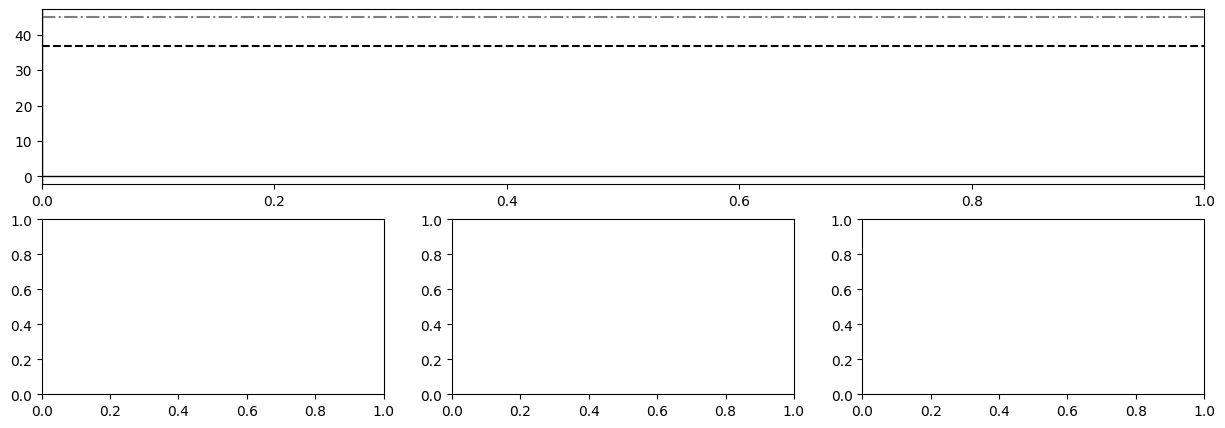

In [ ]:
### Parameters
# Simulation
dt_sim = 1.0 # s
time_span = 60.0 * 3 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

# LED
LEDpar = LEDparams()
dimensions = LEDpar.dimensions

# Controller
dt_d = 2.0
T_cell_ref = conv_temp(37.0, 'C', 'K') # K


### Loop
## First iterable variable
num_traj_1 = 2
P_rad_vec = np.empty((num_traj_1, 1))

ratio_decrease = 10 # decrease power of the LED by ... times compared to the maximum

x_matrix_max = np.ones(dimensions) * (2**16 - 1) # max value for 16 bit resolution

scale_factor = 1 / max(num_traj_1 - 1, 1)  # Avoid division by zero for 1 trajectory
x_matrix_norm_list = [x_matrix_max * traj * scale_factor / (2**16 - 1) / ratio_decrease 
                      for traj in range(num_traj_1)]  # from min of zeros to max of ones corrected by the ratio_decrease
# # TODO implement program reader
# x_matrix = np.random.randint(0, 2**16-1, dimensions)
# x_matrix_scaled = x_matrix / (2**16-1) # duty cycle


## Second iterable variable
num_traj_2 = 1
T_amb_vec = conv_temp(np.linspace(45.0, 45.0, num=num_traj_2), 'C', 'K') # K
# T_amb = conv_temp(25.0, 'C', 'K') # K

## Start simulation loop
sim_results_list = []
leg_titles = []
sim_num = 0
for traj_2 in range(num_traj_2):
    for traj_1 in range(num_traj_1):
        # First iterable variable
        x_LED_tot, I_LED, P_rad = LEDpar.program_reader(x_matrix_norm_list[traj_1])
        P_rad_vec[traj_1] = P_rad

        # Second iterable variable
        T_amb = T_amb_vec[traj_2]

        # Initial conditions
        x0 = np.array([0.9,
                       T_amb,
                       T_amb])

        # Model
        model = Model(LEDpar, x0, T_amb0=T_amb)

        T_top_ref = T_amb + (T_cell_ref - T_amb) * (model.R_top_cell + model.R_cell_amb) / model.R_cell_amb

        # PID
        # kp, ki, kd = -2.5, -4.0, 0.0
        # output_limits = (-model.I_HP_max, model.I_HP_max) # A

        # pid_controller_T_top = PIDController_T_top(kp=kp, ki=ki, kd=kd,
        #                                            T_top_ref=T_top_ref, T_cell_ref=T_cell_ref,
        #                                            sampling_time=dt_d, output_limits=output_limits)

        # LQR
        q1 = 0
        q2 = 20 #/ (T_amb0**2)
        q3 = 0
        Q = np.array([[q1, 0, 0],
                      [0, q2, 0],
                      [0, 0, q3]])
        r1 = 10 / model.I_HP_max**2
        r2 = 4
        R = np.array([[r1, 0 ],
                      [0,  r2]])
        
        # A, B, h, C, D, l       = model.get_continuous_linearization(T_ref=T_cell_ref, T_amb=T_amb)
        # lqr_controller         = LQRControllerCont(T_top_ref=T_top_ref, T_cell_ref=T_cell_ref, A=A, B=B, Q=Q, R=R)

        Ad, Bd, hd, Cd, Dd, ld = model.get_discrete_linearization(T_ref=T_cell_ref, T_amb=T_amb, dt_d=dt_d)
        lqr_controller_disc    = LQRControllerDisc(T_top_ref=T_top_ref, T_cell_ref=T_cell_ref, A_d=Ad, B_d=Bd, Q=Q, R=R, sampling_time=dt_d)

        # MPC
        # q1 = 0
        # q2 = 1 / 40
        # q3 = 0
        # Q = np.array([[q1, 0, 0],
        #               [0, q2, 0],
        #               [0, 0, q3]])
        # r1 = 1 / 3
        # r2 = 1
        # R = np.array([[r1, 0 ],
        #               [0,  r2]])
        # prediction_horizon = 20 # s
        # sampling_time = 2 # s
        # discretization_time = 2 # s
        # mpc_controller = MPCController(model=model, T_top_ref=T_top_ref, T_cell_ref=T_cell_ref,
        #                                A_d=Ad, B_d=Bd, h_d=hd, Q=Q, S=Q, R=R,
        #                                pred_time=prediction_horizon, sampling_time=sampling_time, discret_time=discretization_time,
        #                                print_output=True, verbose=False)

        # Save matrices as csv
        # directory = 'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\notebooks\\state_space\\' TODO CHANGE TO GENERAL
        # type = 'continuous' # TODO STILL NEED TO FINISH FUNCTION WITH T_AMB AND T_REF
        # model.save_linearized_model(directory, type) #TODO adapt to new definitions with T_ref and T_amb
        # type = 'discrete'
        # model.save_linearized_model(directory, type, Ts=dt_disc)

        # Simulation
        sim = Simulation(model=model, controller=lqr_controller_disc, dt_sim=dt_sim, time_span=time_span)

        # Run the simulation
        # results = sim.run(with_initial_time=True, initial_time_span=10)
        
        results['id_sim']    = sim_num
        results['id_traj_1'] = traj_1
        results['id_traj_2'] = traj_2
        sim_results_list.append(results)

        # Titles for legend and figures
        title_T_amb = r"$T_\mathrm{amb} =$" + f"{round(conv_temp(T_amb, 'K', 'C'))}°C"
        title_P_rad = r"$P_\mathrm{led,rad} =$" + f"{P_rad:.1f}W"
        
        # P_LED = np.mean(results["U_BT"].to_numpy()) * I_LED * x_LED_tot # W
        # title_P_LED = r"$P_\mathrm{LED} =$" + f"{P_LED:.1f}W"

        E_BT_tot = np.trapezoid(results["U_BT"].to_numpy() * results["I_BT"].to_numpy(), results["time"].to_numpy()) # J
        title_E_BT = r"$E_\mathrm{bt}^\mathrm{tot} =$" + f"{E_BT_tot:.2f}J"

        fig_title = title_P_rad + "     " + title_E_BT + "     " + title_T_amb
        leg_title = title_P_rad + "," + title_T_amb

        leg_titles.append(leg_title)

        # Save plot
        filename = f"T_amb_{round(conv_temp(T_amb, 'K', 'C'))}" + "_" + f"P_rad_{P_rad:.1f}W"
        filename = filename.replace(".", "_")

        # Plot sim results
        sim.plot_time_results(fig_title, save_plot=False, filename=filename)
        sim.plot_current_temperature(fig_title, save_plot=False, filename=filename)

        # Increase counter
        sim_num = sim_num + 1

# All results
all_results_df = pd.concat(sim_results_list).set_index(['id_sim', 'id_traj_1', 'id_traj_2', 'time'])

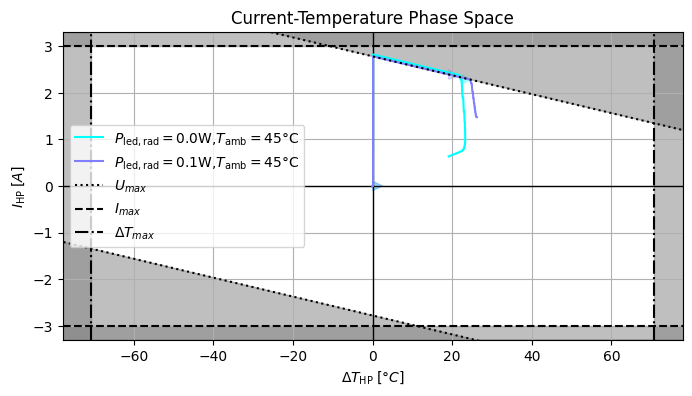

In [ ]:
colormap = plt.colormaps['cool']
sim_len = sim.time_steps

## Arrows
# Steps and thresholds to sparse the arrows
arrow_step = 80
# threshold_dx = 1.0
# threshold_dy = 0.003

# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
# # Remove noise
# window_size = 20
# smoothed_x_sim = moving_average(x_sim, window_size)
# smoothed_y_sim = moving_average(y_sim, window_size)

# dx = np.diff(smoothed_x_sim)
# dy = np.diff(smoothed_y_sim)

# # Mask to filter and get only transients
# arrow_mask = (np.abs(dx) > threshold_dx) | (np.abs(dy) > threshold_dy)
# arrow_mask = np.concatenate((np.zeros(window_size), arrow_mask))
# arrow_mask = np.cumsum(arrow_mask[::-1]) > 0
# arrow_mask = arrow_mask[::-1]

# arrow_x_vec = x_sim[arrow_mask]
# arrow_y_vec = y_sim[arrow_mask]

# arrow_dx_vec = dx[arrow_mask[window_size:]]
# arrow_dy_vec = dy[arrow_mask[window_size:]]

# arrow_x_vec = arrow_x_vec[::arrow_step]
# arrow_y_vec = arrow_y_vec[::arrow_step]
# arrow_dx_vec = arrow_dx_vec[::arrow_step]
# arrow_dy_vec = arrow_dy_vec[::arrow_step]

# Voltage constraints
x_vec = np.linspace(-100, 100, sim_len)
y_vec_min, y_vec_max = model.get_constraints_U_BT2I_HP(x_vec)

### Plot
plt.figure(figsize=(8, 4))
plt.axhline(y=0, lw=1, color='black', label='_nolegend_')
plt.axvline(x=0, lw=1, color='black', label='_nolegend_')
# Group by id_sim
for sim_id, group in all_results_df.groupby(level='id_sim'):
    # Compute x and y values for this trajectory
    x_sim = group["T_bot"].to_numpy() - group["T_top"].to_numpy()
    y_sim = group["I_HP"].to_numpy()

    # Plot each trajectory
    traj_color = colormap(sim_id / (num_traj_1 * num_traj_2))
    plt.plot(x_sim, y_sim, label=leg_titles[sim_id], color=traj_color)
    for i in range(0, len(x_sim) - arrow_step, arrow_step):
        plt.arrow(
            x_sim[i], y_sim[i], 
            x_sim[i + 1] - x_sim[i], y_sim[i + 1] - y_sim[i], 
            head_width=0.2, head_length=2.5, fc=traj_color, ec=traj_color, alpha=0.3
        )

x_lim_max = model.DeltaT_max * 1.1
y_lim_max = model.I_HP_max * 1.1

plt.plot(x_vec, y_vec_max, color='black', linestyle=':', label=r'$U_{max}$')
plt.fill_between(x_vec, y_vec_max, y_lim_max, color='gray', alpha=0.5)

plt.plot(x_vec, y_vec_min, color='black', linestyle=':')
plt.fill_between(x_vec, y_vec_min, -y_lim_max, color='gray', alpha=0.5)

plt.axhline(y=model.I_HP_max, color='black', linestyle='--', label=r'$I_{max}$')
plt.fill_between(x_vec, model.I_HP_max, y_lim_max, color='gray', alpha=0.5)

plt.axhline(y=-model.I_HP_max, color='black', linestyle='--')
plt.fill_between(x_vec, -model.I_HP_max, -y_lim_max, color='gray', alpha=0.5)

plt.axvline(x=model.DeltaT_max, color='black', linestyle='-.', label=r'$\Delta T_{max}$')
plt.fill_betweenx([-y_lim_max, y_lim_max], model.DeltaT_max, x_lim_max, color='gray', alpha=0.5)

plt.axvline(x=-model.DeltaT_max, color='black', linestyle='-.')
plt.fill_betweenx([-y_lim_max, y_lim_max], -model.DeltaT_max, -x_lim_max, color='gray', alpha=0.5)

# Configure plot
plt.xlim(-model.DeltaT_max * 1.1, model.DeltaT_max * 1.1)
plt.ylim(-model.I_HP_max * 1.1, model.I_HP_max * 1.1)
plt.xlabel(r'$\Delta T_\mathrm{HP} \; [°C]$')
plt.ylabel(r'$I_\mathrm{HP} \; [A]$')
plt.title('Current-Temperature Phase Space')
plt.legend()
plt.grid()
plt.show()

array([[0.        ],
       [0.10868035]])

array([[-8.],
       [-8.]])

array([[318.15]])

array([[False]])

TypeError: Dimensions of C (1, 1) should be one smaller than X(2) and Y(1) while using shading='flat' see help(pcolormesh)

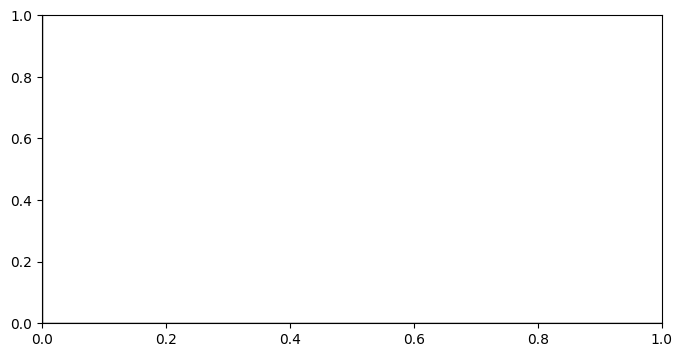

In [5]:
Delta_T_vec = T_cell_ref - T_amb_vec

X, Y = np.meshgrid(P_rad_vec, Delta_T_vec, indexing='ij')

display(X)
display(Y)

# Slice all_results to get last value of T_cell for each simulation
tot_steps = sim.time_steps + sim.initial_time_steps
last_T_cell_value_df = all_results_df["T_cell"][(tot_steps - 1)::tot_steps] # K

# Order data in a matrix: rows traj_1 and columns traj_2
last_T_cell_value_matrix = (
    last_T_cell_value_df
    .reset_index()
    .pivot(index='id_traj_2', columns='id_traj_1', values='T_cell')
    .to_numpy()
) # K

display(last_T_cell_value_matrix)

# Boolean matrix to check if the reference is tracked
tol = 0.5 # °C
Z = np.abs(last_T_cell_value_matrix - T_cell_ref) <= tol
# Z = np.flipud(Z)
display(Z)

### Plot
plt.figure(figsize=(8, 4))
plt.axhline(y=0, lw=1, color='black', label='_nolegend_')
plt.axvline(x=0, lw=1, color='black', label='_nolegend_')
plt.pcolormesh(X.T, Y.T, Z.astype(int), shading='auto', cmap='RdYlGn')
plt.colorbar(label='Not Tracked to Tracked')
plt.scatter(X.T, Y.T, c='black', marker='o', s=10, label='_nolegend_')

# Configure plot
plt.xlim(left=0)
plt.xlabel(r'$P_\mathrm{rad} \; [W]$')
plt.ylabel(r'$\Delta T = T_\mathrm{cell,ref} - T_\mathrm{amb} \; [°C]$')
plt.title('Operational Space')
plt.grid()
plt.show()